## 04 - Modelling

## Setting up Colab Environment if in Colab
The analyses outlined in this notebook relies on the estimators provided by the RAPIDS AI CUML library (https://docs.rapids.ai/api), which provides a sci-kit learn-like API for implementations of machine learning algorithms that are specifically configured to run on GPU hardware. Using this library will significantly speed up the computation time associated with the dimensionality reduction we conduct towards the end of this notebook.

As I do not personally have access to a GPU, the GPU-enabled part of this notebook is run on Google's Colab Notebook environment, which offers GPU access for free. In the cell belows below, we define the functions required to setup a 25GB RAM Colab Notebook Environment with the packages necessary for the code to function.

## Optional - Colab Setup

In [ ]:
def upgrade_runtime_ram():
    meminfo = subprocess.getoutput('cat /proc/meminfo').split('\n')

    memory_info = {entry.split(':')[0]: int(entry.split(':')[1].replace(' kB','').strip()) for entry in meminfo}

    if memory_info['MemTotal'] > 17000000:
        return

    a = []
    while(1):
        a.append('1')

def restart_runtime():
    os.kill(os.getpid(), 9)

In [ ]:
def setup_rapids():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    device_name = pynvml.nvmlDeviceGetName(handle)
    if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
        print("Wrong GPU - Restarting Runtime")
        restart_runtime()


    # clone RAPIDS AI rapidsai-csp-utils scripts repo
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git

    # install RAPIDS
    !bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13


    # set necessary environment variables 
    dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
    sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
    sys.path

    # update pyarrow & modules 
    exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [ ]:
def setup_conda():
    if not 'Miniconda3-4.5.4-Linux-x86_64.sh' in os.listdir():
        !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local

    if not ('EPFL-Capstone-Project' in os.listdir()) and (os.getcwd().split('/')[-1] != 'EPFL-Capstone-Project'):
        !git clone https://github.com/helmigsimon/EPFL-Capstone-Project  
    if 'EPFL-Capstone-Project' in os.listdir():
        os.chdir('EPFL-Capstone-Project')

    !conda env create -f environment.yml
    !conda activate exts-ml

In [ ]:
def setup_drive():
    #Mounting Google Drive
    global drive
    from google.colab import drive
    drive.mount('/content/drive')

In [5]:
import sys,os,subprocess

upgrade_runtime_ram()
setup_drive()

#Setting up PyPi Packages
!pip install geopandas sparse-dot-topn pdpipe category-encoders catboost
import geopandas as gpd
import sparse_dot_topn.sparse_dot_topn as ct
import pdpipe as pdp
import category_encoders

#Setting up Conda Packages
setup_conda()

#Initializing NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')

#Setting up RAPIDS AI
import pynvml
setup_rapids()

from cuml import UMAP

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Solving environment: failed

ResolvePackageNotFound: 
  - libiconv==1.15=h0b31af3_1006
  - markupsafe==1.1.1=py36h37b9a7d_1
  - cfitsio==3.470=h84d2f63_2
  - libpq==12.2=h554dc5a_0
  - tensorflow-base==1.12.0=mkl_py36h70e0e9a_0
  - h5py==2.10.0=nompi_py36h106b333_102
  - scipy==1.4.1=py36h82752d6_0
  - openjpeg==2.3.1=h254dc36_3
  - expat==2.2.9=h4a8c4bd_2
  - libssh2==1.8.2=hcdc9a53_2
  - llvm-openmp==9.0.1=h28b9765_2
  - statsmodels==0.11.1=py36h37b9a7d_1
  - tzcode==2019a=h01d97ff_1002
  - libxml2==2.9.10=h53d96d6_0
  - sparse_dot_topn==0.2.9=py36h863e41a_0
  - numpy==1.18.1=py36hde6bac1_0
  - libnetcdf==4.7.4=nompi_he461dc0_101
  - libcurl==7.68.0=h709d2b2_0
  - libgdal==3.0.4=hec54991_3
  - grpcio==1.23.0=py36h7c1f37e_1
  - libopenblas==0.3.9=h3d69b6c_0
  - tensorflow==1.12.0=mkl_py36h2b2bbaf_0
  - kealib==1.4.12=h2324030_0
  - psutil==5.7.0=py36h37b9a7d_1
  - c-ares==1.15.0=h01d97ff_1001
  - nodejs==13.10.1=h38d8c5a_0
  - jpeg==9c=h1de35cc_1001
  - gettext==0.19.8.1=h46ab8bc_1002

## Imports

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, train_test_split,  KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, RobustScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.decomposition import PCA
from category_encoders import LeaveOneOutEncoder

In [ ]:
from lib.transformers import *
from lib.pipelines import *
from lib.processing import save_to_pkl, load_from_pkl
from lib.visualization import GridSearchPlotter
from data.util.paths import DATA_PATH

In [ ]:
from cuml import LinearRegression, Ridge, RandomForestRegressor, UMAP
from catboost import CatBoostRegressor

## Loading Data
First, we load the dataset that we have prepared in the previous notebook, ``03-DatasetPrep``

In [ ]:
metadata_df, image_embeddings_df = tuple(load_from_pkl(i,DATA_PATH) for i in ('metadata','image_embeddings'))
df = metadata_df.merge(image_embeddings_df,how='inner',on='release_id')

After merging, we will take care of additional outliers that need to be addressed, namely for ``number_of_tracks``, ``running_time``, and the UMAP dimensionality reduction outputs, which were discussed in 02-Visualization&Cleaning. ``number_of_tracks`` and ``running_time`` suffer from massive outlier values which skew the distribution of the features and as such must be taken out of contention. For the case of ``running_time``, we remove those albums with that last over 3 hours, in the interest of focusing our attention on albums of a standard length.

In [ ]:
df = OutlierRemover(features=['number_of_tracks'] + [i for i in df.columns if 'umap' in i]).fit_transform(df[(df['running_time'] < 180) | (df['running_time'].isna())])

In [ ]:
del metadata_df, image_embeddings_df

In [12]:
col_set = {
    'format': {
        'description': 'format_description_', 
        'name': 'format_name_', 
        'text': ('format_text_clean'),
        'quantity': ('format_quantity')
    },
    'geography': {
        'superregion': 'superregion_',
        'region': 'region_',
        'country': 'country_'
    },
    'timeperiod': {
        'period': 'period_',
        'era': 'era_'
    },
    'style': 'style_',
    'null': None,
    'indicator': lambda x: x.max() == 1 and x.min() == 0,
    'image_embedding': 'images_umap_',
}
column_store = ColumnStore()
column_store.fit(df,col_set)

## Preparing for Machine Learning
Next, we split our dataset, ``df``, into train and test sets, which is crucial for the training and ultimate evaluation of the machine learning models we will build in this notebook. We also apply an imputation of missing values for the ``average_rating`` feature at this stage. Since we are relying on the mean for the imputation of ``average_rating`` and ``running_time``, it is crucial that this step is taken after the splitting of train and test datasets, in order to avoid datapoints from the test set influencing the values of predictors we are using to build our models. We also choose to apply additional imputation steps here for ``units_for_sale`` and ``artist`` as making use of the ``SimpleImputer`` transformer within our pipelines would compromise the format of our data.

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(df.drop('market_value',axis=1),df.market_value,random_state=0)

In [ ]:
units_for_sale_imputer = SimpleImputer(strategy='constant',fill_value=0)
average_rating_imputer = SimpleImputer(strategy='mean')
running_time_imputer = RunningTimeImputer('running_time','number_of_tracks')

In [ ]:
X_tr['units_for_sale'] = units_for_sale_imputer.fit_transform(X_tr['units_for_sale'].values.reshape(-1,1))
X_te['units_for_sale'] = units_for_sale_imputer.transform(X_te['units_for_sale'].values.reshape(-1,1))

X_tr['average_rating'] = average_rating_imputer.fit_transform(X_tr['average_rating'].values.reshape(-1,1))
X_te['average_rating'] = average_rating_imputer.transform(X_te['average_rating'].values.reshape(-1,1))

X_tr['artist'] = X_tr['artist'].replace({np.nan:'Unknown'})
X_te['artist'] = X_te['artist'].replace({np.nan:'Unknown'})

X_tr = running_time_imputer.fit_transform(X_tr)
X_te = running_time_imputer.transform(X_te)

Finally, as we are dealing with a fairly high dimensional dataset, we create a smaller training dataset for the purposes of tuning the hyperparameters of the more sophisticated algorithms we are testing in this notebook. This will allow us to iterate quickly in the process of tuning our hyperparameters.

In [ ]:
df_sample = pd.concat([X_tr,y_tr],axis=1).sample(frac=0.1)
X_tr_sample = df_sample.drop('market_value',axis=1)
y_tr_sample = df_sample['market_value']

## Setting up Dummy Regression for baseline
In order to be able to interpret the results we obtain from our models, we must first set a benchmark which we expect our models to surpass. In our case, we will be employing the sci-kit learn DummyRegressor using the 'mean' strategy, and use this to calculate the baseline values for Mean Absolute Error, our evaluation metric of choice in this project.

In [ ]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_tr,np.log(y_tr).values)
dummy_pred = dummy_regressor.predict(X_te)

First, we will naively evaluate the performance of our dummy regressor by calculating the Mean Absolute Error using our predictions and the log of the ``market_value`` feature of our test set. The Mean Absolute Error (MAE) is an interpretable metric which will allow us to evaluate the error of our models in terms of the deviation from the actual price of each sample on average. For the prediction of a straightforward target feature such as ``market_value``, this is an attractive property, as it will allow us to more uniquely understand whether our models are at all useful.

The results from our evaluation below cannot, however, be interpreted as one would normally interpret a Mean Absolute Error for an untransformed target feature. As we have log-linearized the target feature, the Mean Absolute Error in this case does not represent the mean difference in prediction we can expect from our model with respect to the actual value of the untransformed target variable, which we seek in this case in order to be able to interpret the quality of the model with respect how far it is from predicting the true price of a given Jazz album. To do so, we must exponentiate the predictions of our model and evaluate these with respect to the untransformed target feature values, which allows us to interpret the performance of the model in terms of mean deviation of the model from the actual album value using price as the denomination.  This practice of exponentiating our predictions and comparing these to the untransformed values of our test set will be continued throughout this notebook, and will be key in evaluating whether or not our models can be usefully predict Jazz album market value.

In [18]:
mean_absolute_error(np.log(y_te),dummy_pred)

0.6755136430676346

In [19]:
dummy_mae = mean_absolute_error(y_te,np.exp(dummy_pred))
dummy_mae

10.467051614208396

The results above show that the fit of the DummyRegressor is very poor with a high MAE given the scale of the data, indicating that the average magnitude of the error of its predictions is 10.43 USD. Clearly, any acceptable model must significantly improve on this MAE value.

## Model Roadmap
In what follows, we will be attempting to predict the ``market_value`` of Jazz Album on the basis of their non-musical characteristics, using models built with the help of machine learning algorithms. For this analysis, we will be making use of the following machine learning algorithms to build our models:
- Linear Regression
- Ridge Regression
- Random Forest
- CatBoost

In so doing, we will also try to identify the difference in predictive power that a model built with Full Information, or all available features, has in comparison to a model built only using those features that are ostensibly available for evaluation by patrons of record stores. As such, we will be building two models each to predict ``market_value`` using the machine learning algorithms identified above, in order to test whether the information that record store patrons lack significantly inhibits their ability to make a prediction of the ``market_value`` of a given Jazz album.

## Linear Regression
For our first pair of models, we will use Linear Regression. Linear Regression is a simple algorithm which lends itself well to quickly establishing a non-dummy baseline to better understand the possible performance of our final and preferred model. The ``cuml`` implementation of this estimator has few hyperparameters to tune, and is quick to build.

## Linear Regression - Record Store
To build and evaluate our Linear Regression model for the 'Record Store' scenario, we will create a pipeline which applies the transformations necessary to prepare the dataset for the application of this algorithm. This pipeline forms the basis for the transformations we will apply throughout this notebook, in particular for the Ridge Regression algorithm. 

The processing pipeline follows the following steps:
1. Encoding categorical features with high cardinality using Leave One Out Encoding
    - In order to be able to benefit from the information encoded within the categorical features of ``artist``, ``label``, ``format_text`` and ``master_id``, we make use of Leave One Out Encoding
    - This approach to categorical feature encoding is beneficial for the purposes of this project as it helps keep the dimensionality of our dataset from exploding via similar techniques such as OneHotEncoding, while still being able to exploit the relationship between the given feature and the target variable
    - Leave One Out Encoding works by calculating the mean of the target feature for all the records containing a given value for each categorical feature being encoded.
2. Removing Unnecessary/Inappropriate Columns
    - As has been outlined previously, in this step of our analysis, we aim to predict the ``market_value`` of a given Jazz album using only those non-musical attributes which are ostensibly available for evaluation by record store patrons
    - As such, we remove those features pertaining to the Full Information scenario, as well as non-encoded features that will not be leveraged for estimation, such as ``track_titles`` and ``thumb_url``
3. Encoding of ``year``
    - Following best practices, we one-hot encode the ``year`` feature, in order to reinforce its status as a categorical, not numerical feature.
4. Standardization
    - Following best practices, we standardize the non-embedding features used for the prediction of ``market_value``. We forgo standardization of the features generated by UMAP in order to retain their structure
5. Normalization
    - In order to mitigate the impact of scale differences on our results, we normalize the range of our features to lie between 0 and 1

Finally, we construct the ``record_store_lr_pipe``, which applies the aforementioned transformation pipeline and the Linear Regression algorithm we have discussed previously. As the ``cuml`` implementation offers no relevant hyperparameters to tune, we make use of the estimator as is. The use of GridSearch in the estimator is superfluous in this instance, as we are not searching over a hyperparameter space, but is useful for the natively supported cross validation, which we use to get an understanding of the performance of our model.

In [ ]:
record_store_regression_removal_columns = set([
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','country','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','title', 'release_id','master_id'
])

record_store_regression_transformer = ColumnTransformer(transformers=[
  ('one_hot_encoding', OneHotEncoder(dtype=np.uint8,handle_unknown='ignore'), ['year']),
], remainder='passthrough')

record_store_regression_processing = Pipeline([
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','master_id','format_name'])),
    ('record_store_column_remover', ColumnRemover(record_store_regression_removal_columns)),
    ('preprocessing',record_store_regression_transformer),
    ('standardization', RobustScaler()),
    ('normalization', MinMaxScaler())             
])

record_store_lr_pipe = Pipeline([
    ('processing', record_store_regression_processing),
    ('lr', GridSearchCV(
        LinearRegression(),
        param_grid={
            'normalize': [False]
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
    ))
])

In [21]:
record_store_lr_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'master_id',
                                                           'format_name'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown='value',
                                                     random_state=None,
                                                     return_df=True, sigma=None,
                                                     verbose=0)),
                                 ('record_store_column_remover',
                                  Co

In [22]:
record_store_lr_pipe.steps[-1][-1].best_score_

-0.5151283756432046

After performing grid search, we see that our model performs better than our baseline in terms of its negative mean absolute error, which we will now evaluate against the test set by exponentiating our model predictions in order to obtain a clearer picture of the scale of its error.

In [23]:
record_store_lr_pred = record_store_lr_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [24]:
record_store_lr_mae = mean_absolute_error(y_te,np.exp(record_store_lr_pred))
record_store_lr_mae

8.386369608231323

In [ ]:
def print_results(algorithm,algorithm_mae,baseline,baseline_mae):
    mae_diff = algorithm_mae - baseline_mae

    print(f'{algorithm} performance wrt {baseline} is: \nMAE: {np.round(mae_diff,3)}')

In [26]:
print_results('Linear Regression',record_store_lr_mae,'Dummy Regressor',dummy_mae)

Linear Regression performance wrt Dummy Regressor is: 
MAE: -2.081


In comparison to our baseline model, we see there has been a clear improvement in performance using the Linear Regression model, with the Mean Absolute Error decreasing by just over 1.5 USD. However, despite this improvement in performance, the Linear Regression model cannot be argued to be a reliable model in the prediction of Jazz album market value, with a very large mean deviation from the price of a given record. As this is our best performing algorithm thus far, it will henceforth be used as the benchmark for following evaluations of algorithms.

As a next step, we will investigate whether the inclusion of the Full Information suite of features will improve the performance for this algorithm.

## Linear Regression - Full Information
In comparison to the previous model, we make only a small change to the pipeline that builds the Linear Regression model for the Full Information scenario. By retaining the features of ``unit_for_sale``, ``community_have``, ``community_want``, ``average_rating`` and ``rating_count``, we incorporate the broader scope of information available to us by using the Discogs.com platform information. In what follows, we attempt to identify whether this makes a substantive difference in the prediction of the ``market_value`` target feature for Jazz albums within the Linear Regression framework.

In [ ]:
full_information_regression_transformer = record_store_regression_transformer

full_information_columns = set([
    'units_for_sale','community_have','community_want','average_rating','rating_count'
])
full_information_regression_removal_columns = record_store_regression_removal_columns - full_information_columns

full_information_regression_processing = Pipeline([
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','master_id','format_name'])),
    ('record_store_column_remover', ColumnRemover(full_information_regression_removal_columns)),
    ('preprocessing',full_information_regression_transformer),
    ('standardization', RobustScaler()),
    ('normalization', MinMaxScaler())

])

full_information_lr_pipe = Pipeline([
    ('processing', full_information_regression_processing),
    ('lr', GridSearchCV(
        LinearRegression(),
        param_grid={
            'normalize':[False,True]
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
    ))
])

In [28]:
full_information_lr_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'master_id',
                                                           'format_name'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown='value',
                                                     random_state=None,
                                                     return_df=True, sigma=None,
                                                     verbose=0)),
                                 ('record_store_column_remover',
                                  Co

In [29]:
full_information_lr_pipe['lr'].best_score_

-0.4828166224805573

Compared to the results we obtained on the cross validation of the Linear Regression model under the Record Store scenario, we observe a small increase of around 0.05 in the negative mean absolute error. Next we will identify to what extent this improvement is reflected by evaluating our model on the test set.

In [30]:
full_information_lr_pred = full_information_lr_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [31]:
full_information_lr_mae = mean_absolute_error(y_te,np.exp(full_information_lr_pred))
full_information_lr_mae

8.226939165579678

In [32]:
print_results('Linear Regression (FI)',full_information_lr_mae,'Linear Regression (RS)',record_store_lr_mae)

Linear Regression (FI) performance wrt Linear Regression (RS) is: 
MAE: -0.159


Comparing the results of the Record Store and Full Information scenarios, we see there is a small improvement in the performance of the model on the held out test set. This seems to indicate that there is certainly some value to be extracted from the information encoded in the Full Information features, albeit not enough to dramatically improve the performance of the model. Although we cannot identify which features are driving this improvement, it would be safe to assume that the increase in performance comes as a result of the features which proxy the demand and supply for a given record, namely ``community_have`` and ``community_want``. Later, we will investigate this hypothesis via the use of the CatBoost model, which will allow us to identify the most important features in the prediction of ``market_value``.

## Ridge Regression
The next algorithm we will consider in our attempt to predict the ``market_value`` of Jazz albums is the Ridge Regression. It is an offshoot algorithm of Linear Regression, differentiating itself by making use of L2 Regularization as a means of avoiding overfitting. Ridge Regression is often used as an alternative to Linear Regression, and is generally associated with stronger performances.

## Ridge Regression - Record Store
As Ridge Regression operates under the same constraints as Linear Regression, we can make use of the previously defined ``record_store_regression_processing`` pipeline in creating our Ridge Regression training and evaluation pipeline. In this case, we simply replace the Linear Regression in our GridSearchCV step with Ridge Regression, but now also search over the space of the ``alpha`` hyperparameter, which controls the regularization strength of the Ridge Regression algorithm.

In [ ]:
record_store_ridge_pipe = Pipeline([
    ('processing', record_store_regression_processing),
    ('ridge', GridSearchCV(
        Ridge(normalize=False,solver='eig'),
        param_grid={
            'alpha': np.logspace(-4,-1,10),
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
        return_train_score=True
    ))
])

In [34]:
record_store_ridge_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.0s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'master_id',
                                                           'format_name'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown='value',
                                                     random_state=None,
                                                     return_df=True, sigma=None,
                                                     verbose=0)),
                                 ('record_store_column_remover',
                                  Co

In order to get a better sense of the manner in which the magnitude of the `alpha` hyperparameter impacts the Mean Absolute Error of the model, we use the GridSearchPlotter class, which plots the scores obtained over the range of hyperparameter values tested.

In [ ]:
plotter = GridSearchPlotter(record_store_ridge_pipe['ridge'])

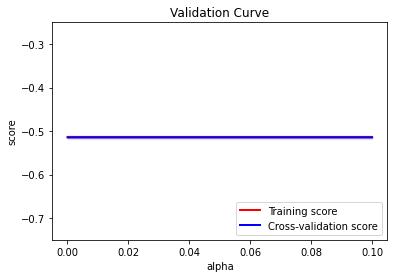

In [36]:
plotter.plot_validation_curve(parameter='alpha',ylim=(-0.75,-0.25))

It seems that there is a negligible impact of altering the value of `alpha` on the mean absolute error performance of the Ridge Regression model.

In [37]:
record_store_ridge_pipe['ridge'].best_score_

-0.5146006666944771

In [38]:
record_store_ridge_pipe['ridge'].best_params_

{'alpha': 0.0001}

As we see from the best score we obtain above, there seems to be a very minor improvement over the performance of the Linear Regression model treated previously. We will test whether this improvement extends to the test set below.

In [39]:
record_store_ridge_pred = record_store_ridge_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [40]:
record_store_ridge_mae = mean_absolute_error(y_te,np.exp(record_store_ridge_pred))
record_store_ridge_mae

8.386952781964636

In [41]:
print_results('Ridge Regression',record_store_ridge_mae,'Linear Regression',record_store_lr_mae)

Ridge Regression performance wrt Linear Regression is: 
MAE: 0.001


As we can see by comparing the Mean Absolute Error scores we obtain from evaluating our model predictions on the test set, there is a negligible improvement in model performance, which leads us to conclude that our regularization efforts are not effective in improving on the performance of Linear Regression in predicting ``market_value``.

## Ridge - Full Information
As in the case for Linear Regression, we will now extend the analysis of the Ridge Regression to the Full Information case, using the same model preprocessing steps as we have done for the Linear Regression model.

In [ ]:
full_information_ridge_pipe = Pipeline([
    ('processing', full_information_regression_processing),
    ('ridge', GridSearchCV(
        Ridge(normalize=False,solver='eig'),
        param_grid={
            'alpha': np.logspace(-4,1,10),
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
        return_train_score=True
    ))
])

In [43]:
full_information_ridge_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.3s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'master_id',
                                                           'format_name'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown='value',
                                                     random_state=None,
                                                     return_df=True, sigma=None,
                                                     verbose=0)),
                                 ('record_store_column_remover',
                                  Co

In [ ]:
plotter = GridSearchPlotter(full_information_ridge_pipe['ridge'])

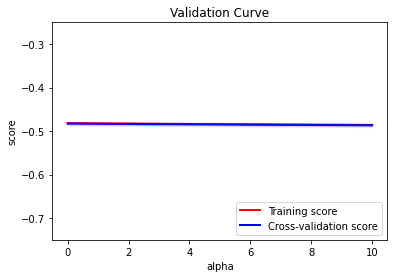

In [45]:
plotter.plot_validation_curve(parameter='alpha',ylim=(-0.75,-0.25))

In [46]:
full_information_ridge_pipe['ridge'].best_score_

-0.4827888676725287

In [47]:
full_information_ridge_pipe['ridge'].best_params_

{'alpha': 0.0001}

In [48]:
full_information_ridge_pred = full_information_ridge_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [49]:
full_information_ridge_mae = mean_absolute_error(y_te,np.exp(full_information_ridge_pred))
full_information_ridge_mae

8.2267548845038

In [50]:
print_results('Ridge Regression',full_information_ridge_mae,'Linear Regression',full_information_lr_mae)

Ridge Regression performance wrt Linear Regression is: 
MAE: -0.0


In [51]:
print_results('Ridge Regression (FI)',full_information_ridge_mae, 'Ridge Regression (RS)',record_store_ridge_mae)

Ridge Regression (FI) performance wrt Ridge Regression (RS) is: 
MAE: -0.16


Just like in the Record Store case, we see no improvement of the Ridge Regression model on the Linear Regression model, further indicating that regularization is ineffective in driving performance for linear models using the data for this project. The difference in performance between the two scenarios for the Ridge Regression models is also almost identical to the Linear Regression case.

## Random Forest
Having obtained wanting results using standard linear regression-based approaches, we will now try the Random Forest approach in order to predict ``market_value``. Random Forest is a powerful algorithm that often perform better than standard regression-based approaches. However, it has been noted that Random Forests can at times have difficulties in accurately predicting outlier values. While we have tried to remove outliers as much as possible, our dataset continues to be defined by a high degree of variation, and as a result even this more sophisticated algorithm may run into issues in improving on the performance of the regression-based approaches outlined previously. 
## Random Forest - Record Store
In preparing the data for prediction with a Random Forest based model, we have to make some adjustments to our preprocessing pipeline. Firstly, we increase the scope of the features we encode via the Leave One Out method, as it keeps the dimensionality of our processed dataset lower. This is important, as high dimensionality can result in poor performance for Random Forest based models. As such, we elect to encode features we had previously dummy encoded, such as ``year``, ``country`` and ``format_name``, using the aforementioned Leave One Out encoding method. The columns that are removed from the dataset are thus adjusted to reflect this change in method.

Additionally, we cast the data to the ``np.float32`` datatype, as this is a strict requirement of the ``cuml`` RandomForestRegressor estimator.

In [ ]:
record_store_random_forest_removal_columns = [
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','country','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','title','release_id'
]
record_store_random_forest_removal_columns.extend(
    [*column_store._geography_country, *column_store._format_name]
)
record_store_random_forest_removal_columns = set(record_store_random_forest_removal_columns)

In [ ]:
record_store_random_forest_preprocessing_pipe = Pipeline([
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id','year','country'])),
    ('record_store_column_remover', ColumnRemover(record_store_random_forest_removal_columns)),
    ('cast_to_32', FunctionTransformer(func=lambda x: x.astype(np.float32).values))
])

random_forest = RandomForestRegressor()

record_store_random_forest_search_pipe = Pipeline([
    ('preprocessing',record_store_random_forest_preprocessing_pipe),
    ('grid_search', GridSearchCV(
        random_forest,
        cv=KFold(n_splits=5,shuffle=True),
        param_grid={
            'n_estimators': np.linspace(10,150,5).astype(int)
        },
        verbose=50,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        return_train_score=True
    ))
])

record_store_random_forest_pipe = Pipeline([
    ('preprocessing',record_store_random_forest_preprocessing_pipe),
    ('random_forest',random_forest)
])

In [54]:
record_store_random_forest_search_pipe.fit(X_tr_sample,np.log(y_tr_sample).values.astype(np.float32))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   17.0s


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   37.4s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   41.5s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:   45.8s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   47.1s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   50.2s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   56.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   56.3s finished


/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id', 'year',
                                                           'country'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown='value',
                                                     random_state=None,
                                                     return_df=True, sigma=None,
                                                     verbose=0)),
                    

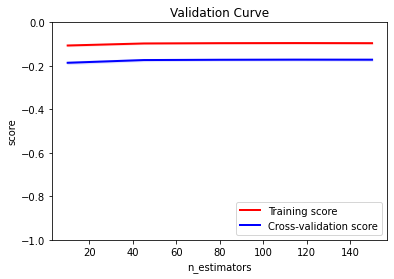

In [55]:
record_store_random_forest_plotter = GridSearchPlotter(record_store_random_forest_search_pipe.steps[-1][1])
record_store_random_forest_plotter.plot_validation_curve(parameter='n_estimators',ylim=(-1,0))

In [56]:
record_store_random_forest_search_pipe.steps[-1][1].best_score_

-0.1710609793663025

In [57]:
record_store_random_forest_search_pipe.steps[-1][1].best_params_

{'n_estimators': 115}

After tuning hyperparameters using GridSearchCV and GridSearchPlotter, we obtain excellent cross-validation results using the Random Forest, with the best score obtained yielding a more than 50% reduction in the magnitude of the Mean Absolute Error we had obtained for previous models. Accordingly, we will train the algorithm on the total dataset, and then evaluate the resulting model on the test set.

In [58]:
record_store_random_forest_pipe.fit(X_tr,np.log(y_tr).values.astype(np.float32))

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id', 'year',
                                                           'country'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown='value',
                                                     random_state=None,
                                                     return_df=True, sigma=None,
                                                     verbose=0)),
                    

In [59]:
record_store_random_forest_te_pred = record_store_random_forest_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [60]:
record_store_random_forest_mae = mean_absolute_error(y_te,np.exp(record_store_random_forest_te_pred))
record_store_random_forest_mae

10.634899748038789

Unfortunately, it seems that when applying the Random Forest algorithm we are not able to replicate the results we obtained in cross validation. The reason for this mismatch is unclear. Unfortunately, the very strong scores on the validation set cannot be reproduced on the test set. After having run multiple tests with different randomly selected test sets, this result continues to hold. This result also holds for when the cross validation is run over the entire training dataset, which implies that this odd mismatch is not retraceable to our choice of deciding to use a smaller sample of the training dataset for cross validation purposes.
Putting the odd results in cross validation aside, which may be a quirk of the ``cuml`` library, it is clear from our results that the Random Forest does not perform well at all for our data. This is likely due to the fact that our data is highly unique across samples, which makes it difficult for the bagging approach of the Random Forest model to draw accurate decision-based inferences on the data.


## Random Forest - Full Information
Having tested the performance of the Random Forest in the Record Store scenario, we now turn our attention to the Full Information scenario. Despite the non-trivial delta in performance we have observed between these scenarios for previous models, due to the very poor performance of the Random Forest model in the Record Store scenario, it is unlikely that we will see a significant improvement in performance upon the introduction of the features included in the Full Information scenario.

In [ ]:
full_information_random_forest_removal_columns = record_store_random_forest_removal_columns - full_information_columns

In [ ]:
full_information_random_forest_preprocessing_pipe = Pipeline([
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id','year','country'])),
    ('record_store_column_remover', ColumnRemover(full_information_random_forest_removal_columns)),
    ('cast_to_32', FunctionTransformer(func=lambda x: x.astype(np.float32).values))
])

full_information_random_forest_search_pipe = Pipeline([
    ('preprocessing',full_information_random_forest_preprocessing_pipe),
    ('grid_search', GridSearchCV(
        random_forest,
        cv=KFold(n_splits=5,shuffle=True),
        param_grid={
            'n_estimators': np.linspace(10,200,5).astype(int)
        },
        verbose=50,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        return_train_score=True
    ))
])

full_information_random_forest_pipe = Pipeline([
    ('preprocessing',full_information_random_forest_preprocessing_pipe),
    ('random_forest',random_forest)
])

In [63]:
full_information_random_forest_search_pipe.fit(X_tr_sample,np.log(y_tr_sample).values.astype(np.float32))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.6s


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   47.2s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   52.5s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:  1.2min remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:  1.3min remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:  1

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id', 'year',
                                                           'country'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown='value',
                                                     random_state=None,
                                                     return_df=True, sigma=None,
                                                     verbose=0)),
                    

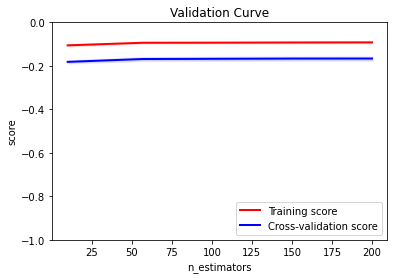

In [64]:
full_information_random_forest_plotter = GridSearchPlotter(full_information_random_forest_search_pipe.steps[-1][1])
full_information_random_forest_plotter.plot_validation_curve(parameter='n_estimators',ylim=(-1,0))

In [65]:
full_information_random_forest_search_pipe.steps[-1][1].best_score_

-0.16600749790668487

In [66]:
full_information_random_forest_search_pipe.steps[-1][1].best_params_

{'n_estimators': 200}

In [67]:
full_information_random_forest_pipe.fit(X_tr,np.log(y_tr).values.astype(np.float32))

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id', 'year',
                                                           'country'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown='value',
                                                     random_state=None,
                                                     return_df=True, sigma=None,
                                                     verbose=0)),
                    

In [68]:
full_information_random_forest_te_pred = full_information_random_forest_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [69]:
full_information_random_forest_mae = mean_absolute_error(y_te,np.exp(full_information_random_forest_te_pred))
full_information_random_forest_mae

10.617872102505165

In [70]:
print_results('Random Forest (FI)',full_information_random_forest_mae,'Random Forest (RS)',record_store_random_forest_mae)

Random Forest (FI) performance wrt Random Forest (RS) is: 
MAE: -0.017


As we can see from the above, we see very similar results in the Full Information scenario as in the Record Store scenario, with an even slight degradation in performance in the Full Information case for the MAE metric. Unlike the results for the linear models we considered, we do not observe that including the Full Information features has any positive impact on the prediction of ``market_value``, although it must be noted that this model does not perform at all well in general, and as was mentioned prior to training, an improvement was not expected.

## CatBoost
For our final attempt at predicting ``market_value`` for Jazz albums, we turn to the CatBoost algorithm. It has been developed fairly recently by Yandex Research, and has shown immense promise, as can be gathered from the following blog post: https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db.
CatBoost is ideally suited for datasets which have high incidence of categorical features, making it a good fit in theory for our use case. 
## CatBoost - Record Store
As for previous algorithms, we begin our evaluation of CatBoost by training the model using the features relevant to the Record Store scenario. For our preprocessing, we simply need to remove the columns that are not relevant for the Record Store scenario. The implementation of the CatBoost algorithm we use here allows us to specify categorical features which are then appropriately encoded by the algorithm. It has been noted that this is a highly important parameter to improve the performance of the algorithm, and as such, we include all features that are categorical in nature, even the ``country`` feature, which we have previously applied dummy encoding for in previous tests of algorithms.

In [ ]:
record_store_catboost_removal_columns = set([
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','title','release_id'
])
record_store_catboost_removal_columns = record_store_catboost_removal_columns.union(column_store._geography_country,column_store._format_name)

In [ ]:
record_store_catboost_processing_pipe = Pipeline([
    ('record_store_column_remover', ColumnRemover(record_store_catboost_removal_columns)),
])

catboost = CatBoostRegressor(
    random_seed=0,
    cat_features=['year','format_text','master_id','format_name','artist','label','country'],
    boosting_type='Ordered',
    n_estimators=100,
    learning_rate=0.1,
    l2_leaf_reg=3,
    border_count=170,
    max_depth=10,
)

record_store_catboost_grid_pipe = Pipeline([
    ('processing', record_store_catboost_processing_pipe),
    ('grid_search', GridSearchCV(
        catboost,
        param_grid={
            #'learning_rate': np.logspace(-3,1,5),
            #'border_count': np.linspace(1,200,5),
            'l2_leaf_reg': [1,3,5,8],
        },
        n_jobs=-1,
        cv=KFold(n_splits=5,shuffle=True),
        verbose=1,
        scoring='neg_mean_absolute_error',
        return_train_score=True)
    )
])

record_store_catboost_pipe = Pipeline([
    ('processing', record_store_catboost_processing_pipe),
    ('catboost',catboost)
])

In [73]:
record_store_catboost_grid_pipe.fit(X_tr_sample,np.log(y_tr_sample))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.9min finished


0:	learn: 0.8535971	total: 217ms	remaining: 21.5s
1:	learn: 0.8361423	total: 347ms	remaining: 17s
2:	learn: 0.8214247	total: 476ms	remaining: 15.4s
3:	learn: 0.8089460	total: 608ms	remaining: 14.6s
4:	learn: 0.7981460	total: 736ms	remaining: 14s
5:	learn: 0.7882747	total: 869ms	remaining: 13.6s
6:	learn: 0.7792782	total: 998ms	remaining: 13.3s
7:	learn: 0.7731773	total: 1.13s	remaining: 13s
8:	learn: 0.7648795	total: 1.26s	remaining: 12.8s
9:	learn: 0.7582406	total: 1.39s	remaining: 12.5s
10:	learn: 0.7522104	total: 1.52s	remaining: 12.3s
11:	learn: 0.7470618	total: 1.66s	remaining: 12.1s
12:	learn: 0.7425045	total: 1.79s	remaining: 12s
13:	learn: 0.7389164	total: 1.92s	remaining: 11.8s
14:	learn: 0.7358380	total: 2.06s	remaining: 11.6s
15:	learn: 0.7329781	total: 2.19s	remaining: 11.5s
16:	learn: 0.7302168	total: 2.25s	remaining: 11s
17:	learn: 0.7261471	total: 2.39s	remaining: 10.9s
18:	learn: 0.7233391	total: 2.45s	remaining: 10.4s
19:	learn: 0.7205610	total: 2.58s	remaining: 10.3s


Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('record_store_column_remover',
                                  ColumnRemover(remove_columns={'average_rating',
                                                                'community_have',
                                                                'community_want',
                                                                'country_albania',
                                                                'country_algeria',
                                                                'country_andorra',
                                                                'country_angola',
                                                                'country_argentina',
                                                                'country_armenia',
                                                                'country_aruba',
                 

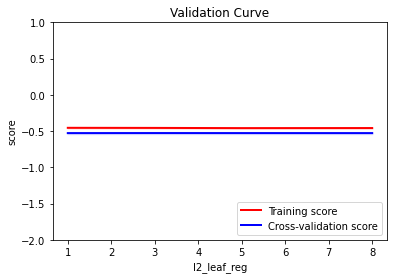

In [74]:
record_store_catboost_plot = GridSearchPlotter(record_store_catboost_grid_pipe.steps[-1][1])
record_store_catboost_plot.plot_validation_curve(parameter='l2_leaf_reg',ylim=(-2,1))

In [75]:
record_store_catboost_grid_pipe.steps[-1][1].best_score_

-0.5258783340691499

In [76]:
record_store_catboost_grid_pipe.steps[-1][1].best_params_

{'l2_leaf_reg': 3}

After searching over the hyperparameter space, we obtain cross validation results that end up looking fairly similar to those that we obtained from the Linear and Ridge regressions. This indicates that there seems to be a clear upper limit in the performance of our algorithms on our data, and that even this state of the art algorithm may not significantly improve on the performance of our previous results. 

In [77]:
record_store_catboost_pipe.fit(X_tr,np.log(y_tr))

0:	learn: 0.8448014	total: 327ms	remaining: 32.3s
1:	learn: 0.8242734	total: 605ms	remaining: 29.6s
2:	learn: 0.8078409	total: 872ms	remaining: 28.2s
3:	learn: 0.7894780	total: 1.14s	remaining: 27.4s
4:	learn: 0.7748192	total: 1.33s	remaining: 25.2s
5:	learn: 0.7618477	total: 1.6s	remaining: 25s
6:	learn: 0.7515483	total: 1.86s	remaining: 24.7s
7:	learn: 0.7425225	total: 2.13s	remaining: 24.5s
8:	learn: 0.7343495	total: 2.41s	remaining: 24.3s
9:	learn: 0.7274379	total: 2.67s	remaining: 24.1s
10:	learn: 0.7208288	total: 2.94s	remaining: 23.8s
11:	learn: 0.7158437	total: 3.21s	remaining: 23.6s
12:	learn: 0.7080936	total: 3.48s	remaining: 23.3s
13:	learn: 0.7013542	total: 3.77s	remaining: 23.1s
14:	learn: 0.6955660	total: 4.03s	remaining: 22.9s
15:	learn: 0.6908069	total: 4.31s	remaining: 22.6s
16:	learn: 0.6866112	total: 4.58s	remaining: 22.4s
17:	learn: 0.6829455	total: 4.84s	remaining: 22.1s
18:	learn: 0.6798355	total: 5.11s	remaining: 21.8s
19:	learn: 0.6770859	total: 5.39s	remaining:

Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('record_store_column_remover',
                                  ColumnRemover(remove_columns={'average_rating',
                                                                'community_have',
                                                                'community_want',
                                                                'country_albania',
                                                                'country_algeria',
                                                                'country_andorra',
                                                                'country_angola',
                                                                'country_argentina',
                                                                'country_armenia',
                                                                'country_aruba',
                 

In [ ]:
record_store_catboost_te_pred = record_store_catboost_pipe.predict(X_te)

In [79]:
record_store_catboost_mae = mean_absolute_error(y_te,np.exp(record_store_catboost_te_pred))
record_store_catboost_mae

7.803111882768742

In [80]:
print_results('CatBoost',record_store_catboost_mae,'Linear Regression',record_store_lr_mae)

CatBoost performance wrt Linear Regression is: 
MAE: -0.583


Despite the fairly similar looking results we obtained on our cross validation, we are able to improve on the performance of our best performing previous models by a substantial margin, with a final mean absolute error value on our test predictions of 7.79. While this performance is still far from representing a strong model for the prediction of ``market_value``, it is clear that by using the CatBoost algorithm, which is distinctly engineered to perform well for datasets with categorical features, we are able to obtain a clear improvement in performance with respect to the linear models.

## CatBoost - Full Information
Having witnessed an encouraging improvement in performance via the use of the CatBoost algorithm for our prediction problem in the Record Store scenario, we now turn to the Full Information scenario, and attempt to identify whether a significant difference can be observed in the predictive performance of CatBoost between these two scenarios.

In [ ]:
full_information_catboost_removal_columns = record_store_catboost_removal_columns - full_information_columns

In [ ]:
full_information_catboost_processing_pipe = Pipeline([
    ('record_store_column_remover', ColumnRemover(full_information_catboost_removal_columns)),
])

full_information_catboost_grid_pipe = Pipeline([
    ('processing', full_information_catboost_processing_pipe),
    ('grid_search', GridSearchCV(
        catboost,
        param_grid={            
            #'learning_rate': np.logspace(-3,1,5),
            #'border_count': np.linspace(1,200,5),
            'l2_leaf_reg': [1,3,5,8],
        },
        n_jobs=3,
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=50,
        return_train_score=True)
    )
])

full_information_catboost_pipe = Pipeline([
    ('processing', full_information_catboost_processing_pipe),
    ('catboost',catboost)
])

In [83]:
full_information_catboost_grid_pipe.fit(X_tr_sample,np.log(y_tr_sample).values)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   24.6s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   24.8s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:   25.8s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:   47.6s


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:   48.6s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:   49.0s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done  16 out of  20 | elapsed:  2.5min remaining:   37.2s
[Parallel(n_jobs=3)]: Done  17 out of  20 | elapsed:  2.5min remaining:   26.8s
[Parallel(n_jobs=3)]: Done  18 out of  20 | elapsed:  2.6min remaining:   17.2s
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  2.8min remaining:    0.0s
[Parallel

Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('record_store_column_remover',
                                  ColumnRemover(remove_columns={'country_albania',
                                                                'country_algeria',
                                                                'country_andorra',
                                                                'country_angola',
                                                                'country_argentina',
                                                                'country_armenia',
                                                                'country_aruba',
                                                                'country_australia',
                                                                'country_austria',
                                                                'country_azerbaijan',
         

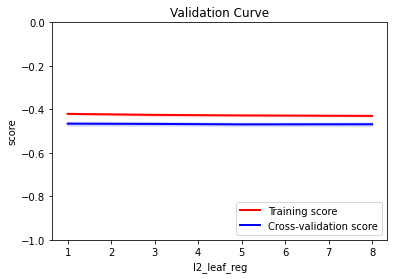

In [84]:
full_information_catboost_plot = GridSearchPlotter(full_information_catboost_grid_pipe.steps[-1][1])
full_information_catboost_plot.plot_validation_curve(parameter='l2_leaf_reg',ylim=(-1,0))

In [85]:
full_information_catboost_grid_pipe.steps[-1][1].best_score_

-0.4655173351787941

In [86]:
full_information_catboost_grid_pipe.steps[-1][1].best_params_

{'l2_leaf_reg': 1}

After having performed grid search on our hyperparameters for CatBoost, we observe that in the final stages, we obtain cross validation Mean Absolute Error that is 0.06 lower than the cross validation Mean Absolute Error for the Record Store scenario. This improvement in Mean Absolute Error is a promising sign for the performance of our model on the test set.

In [87]:
full_information_catboost_pipe.fit(X_tr,np.log(y_tr))

0:	learn: 0.8353250	total: 361ms	remaining: 35.7s
1:	learn: 0.8057548	total: 700ms	remaining: 34.3s
2:	learn: 0.7802733	total: 1.02s	remaining: 33.1s
3:	learn: 0.7582575	total: 1.34s	remaining: 32.3s
4:	learn: 0.7392930	total: 1.67s	remaining: 31.8s
5:	learn: 0.7233265	total: 2s	remaining: 31.3s
6:	learn: 0.7100145	total: 2.32s	remaining: 30.8s
7:	learn: 0.6966878	total: 2.64s	remaining: 30.4s
8:	learn: 0.6848340	total: 2.97s	remaining: 30s
9:	learn: 0.6753740	total: 3.29s	remaining: 29.7s
10:	learn: 0.6669238	total: 3.62s	remaining: 29.3s
11:	learn: 0.6595110	total: 3.94s	remaining: 28.9s
12:	learn: 0.6534118	total: 4.26s	remaining: 28.5s
13:	learn: 0.6475448	total: 4.59s	remaining: 28.2s
14:	learn: 0.6428631	total: 4.91s	remaining: 27.8s
15:	learn: 0.6382576	total: 5.23s	remaining: 27.4s
16:	learn: 0.6345479	total: 5.54s	remaining: 27s
17:	learn: 0.6298519	total: 5.87s	remaining: 26.7s
18:	learn: 0.6260884	total: 6.22s	remaining: 26.5s
19:	learn: 0.6221769	total: 6.54s	remaining: 26.

Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('record_store_column_remover',
                                  ColumnRemover(remove_columns={'country_albania',
                                                                'country_algeria',
                                                                'country_andorra',
                                                                'country_angola',
                                                                'country_argentina',
                                                                'country_armenia',
                                                                'country_aruba',
                                                                'country_australia',
                                                                'country_austria',
                                                                'country_azerbaijan',
         

In [ ]:
full_information_catboost_te_pred = full_information_catboost_pipe.predict(X_te)

In [89]:
full_information_catboost_mae = mean_absolute_error(y_te,np.exp(full_information_catboost_te_pred))
full_information_catboost_mae

7.183348995545678

In [90]:
print_results('CatBoost (FI)',full_information_catboost_mae,'CatBoost (RS)',record_store_catboost_mae)

CatBoost (FI) performance wrt CatBoost (RS) is: 
MAE: -0.62


As foreshadowed by the improvement in our cross validation Mean Absolute Error, we observe a distinct reduction in the magnitude of our test set Mean Absolute Error for CatBoost, with a reduction of about 0.628. As in the case for linear models, we can identify that the inclusion of the Full Information suite of features results in a stronger model for the prediction of ``market_value``.  Given that this model actually manages to perform much better than previous models, we see this change in performance via the inclusion of the Full Information features as an argument for the importance of these features in being able to predict Jazz album ``market_value``. Nonetheless, it must also be stated that even with this improvement in performance, the model still does not prove to be highly accurate in estimating the ``market_value`` of Jazz albums, which leads us to conclude that on the whole, even with the use highly sophisticated machine learning algorithms, that it is not possible to predict the market value of a Jazz album on the basis of its meta characteristics alone to an acceptable level of error.

## Identification of Feature Importances
As we are making use of the CatBoost algorithm, we benefit from being able to identify the strength of feature importances used in the model. This will allow us to understand what features in our models are proving the most useful in the prediction of ``market_value``.

In [ ]:
full_information_feature_importance_transformation_pipe = full_information_catboost_processing_pipe.fit(X_tr,np.log(y_tr).values)
record_store_feature_importance_transformation_pipe = record_store_catboost_processing_pipe.fit(X_tr,np.log(y_tr).values)

record_store_catboost_feature_importances = dict(zip(
    record_store_feature_importance_transformation_pipe.transform(X_te).columns,
    record_store_catboost_pipe.steps[-1][-1].feature_importances_
))
full_information_catboost_feature_importances = dict(zip(
    full_information_feature_importance_transformation_pipe.transform(X_te).columns,
    full_information_catboost_pipe.steps[-1][-1].feature_importances_
))

In [92]:
pd.Series(record_store_catboost_feature_importances).sort_values(ascending=False).head(20)

artist                                    19.703097
country                                   18.112934
standards_count                           15.247605
format_text                                9.919429
label                                      5.708300
year                                       5.682757
superregion_americas                       3.577738
master_id                                  3.508069
region_latin america and the caribbean     2.745003
region_northern europe                     2.042894
superregion_africa                         1.789132
format_description_LP                      1.410613
format_description_Album                   1.360779
superregion_oceania                        1.323937
style_Other                                1.286455
images_umap_0                              1.245819
era_modern                                 0.797595
running_time                               0.787985
number_of_tracks                           0.775120
images_umap_

In [93]:
pd.Series(full_information_catboost_feature_importances).sort_values(ascending=False).head(20)

community_want                19.703097
country                       18.112934
units_for_sale                15.247605
format_name                    9.919429
label                          5.708300
year                           5.682757
artist                         3.577738
community_have                 3.508069
region_eastern asia            2.745003
region_north america           2.042894
master_id                      1.789132
format_text                    1.410613
format_quantity                1.360779
superregion_asia               1.323937
average_rating                 1.286455
number_of_tracks               1.245819
format_description_Reissue     0.797595
period_fusion                  0.787985
period_cool                    0.775120
format_description_Other       0.566976
dtype: float64

From the above, we observe that the feature importances that are generated in both versions of the model are identical, but with different features attributed to each feature importance.

In the Record Store scenario, we observe that the ``artist`` feature is the most important, along with ``standards_count``, ``country``, ``format_text``, ``label`` and ``year``. These are generally what we would expect to be the most important, with ``standards_count`` being notable as it indicates the importance of domain knowledge in the Record Store scenario. We also observe that ``region_latin america and the caribbean`` is a surprisingly important feature for this model.

In the Full Information scenario, however the most important features takes a wholly new structure, as ``community_want`` and ``units_for_sale`` top  the list of features, along with ``country``, ``format_name``, ``label``, ``year``, ``artist`` and ``community_have``. The dominance of ``community_want`` is not unsurprising, as it reflects the demand for a given album, which economic theory has long underscored as being a fundamental driver of price, and therefore market value within the context of this project. Of the Full Information Scenario specific features, ``units_for_sale`` and ``community_have`` also have amongst the strongest influence on the prediction of ``market_value``. These are reflections of the supply of the album, and as such are also unsurprisingly important, as per economic theory. The most important features list includes many of the same features that were also to be found in the Record Store scenario, albeit in a new order. Most notably, ``artist`` becomes far less important in predicting ``market_value`` than in the Record Store scenario, and ``format_text`` has been replaced with ``format_name``. Additionally, we observe a similar case as in the Record Store scenario, where a specific region exerts substantial influence on the prediction of ``market_value``, namely ``region_eastern asia``. This fluctuation in the regions that are deemed important across models may be due to the generally poor performance of the models as a whole, thereby explaining the element of randomness that is seemingly present in determining the importance of indicators in the prediction task and the lack of consistency in their perfomance.

# Discussion
As a final step, we aggregate and discuss the results of our models.

In [ ]:
algorithms = ('Linear Regression','Ridge Regression','Random Forest','CatBoost')*2
mae = (record_store_lr_mae, record_store_ridge_mae, record_store_random_forest_mae, record_store_catboost_mae,full_information_lr_mae, full_information_ridge_mae, full_information_random_forest_mae, full_information_catboost_mae)
scenario = ['Record Store']*4 + ['Full Information']*4
results = pd.DataFrame({
    'Algorithm': algorithms,
    'Mean Absolute Error': mae,
    'Scenario': scenario
},index=algorithms)

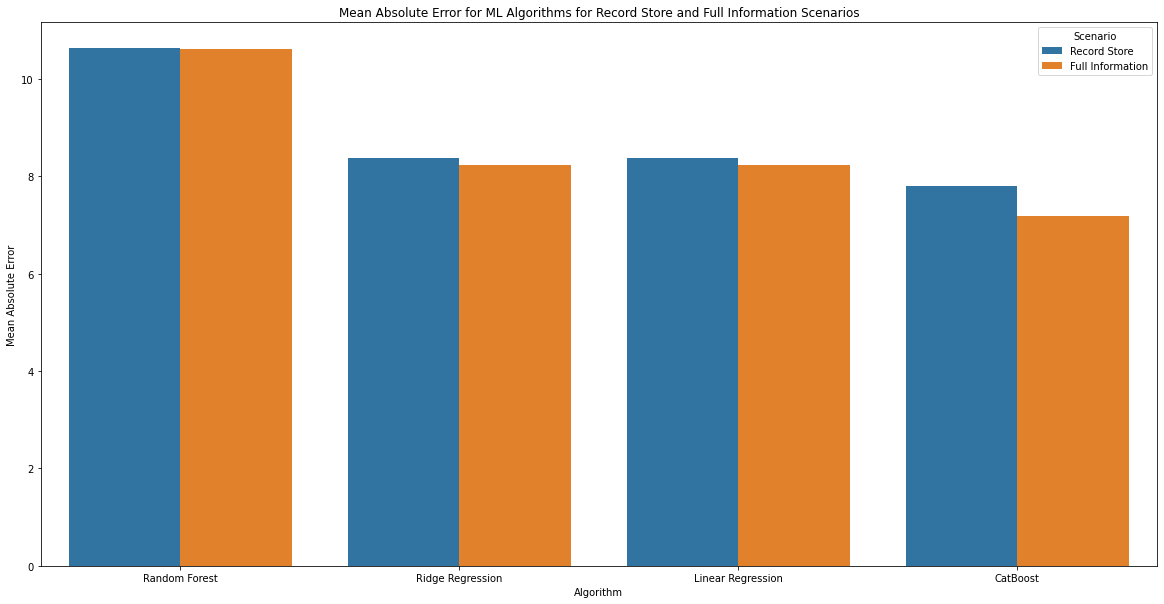

In [95]:
plt.figure(figsize=(20,10))
plt.title('Mean Absolute Error for ML Algorithms for Record Store and Full Information Scenarios')
sns.barplot(x='Algorithm', hue='Scenario', y='Mean Absolute Error', data=results.sort_values(['Mean Absolute Error','Algorithm'],ascending=False))
plt.show()

From the above, we can draw the following conclusions:
1. It is not possible, with the data on Jazz album meta-characteristics used in this project, and the machine learning algorithms we have leveraged, to accurately predict the market value of Jazz albums to an acceptable degree.
2. The inclusion of Full Information features does not seem to make much of a difference for our most poorly performing algorithm, Random Forest, but in the case of Lienar Regression, Ridge Regression & CatBoost, which perform far better and seems to be able to leverage the given data the best, these features make a non-trivial difference in reducing the prediction error of the model.

With respect to the first point, we refer to the following table of descriptive statistics for the ``market_value`` feature.

In [96]:
df['market_value'].describe()

count    161533.000000
mean         16.871736
std          20.021359
min           0.010000
25%           6.410000
50%          10.990000
75%          19.670000
max         235.386631
Name: market_value, dtype: float64

As we can see, ``market_value`` has a mean value of around 16.88, and a standard deviation of around 20.05. While we have been able to predict the market value of Jazz albums at a error magnitude well under the standard deviation of the dataset, this is also the case for the Dummy Regressor baseline we set as our initial benchmark, and as such this is not an indication of the quality of our models for such a noisy dataset. The failure of the algorithms we made use of to accurately predict the market value of Jazz albums is perhaps best understood through interpreting the size of the MAE in the context of a real world use case. If we assume that our best performing model is off by around 7.3 USD, given that the mean value for a record is 16.88 USD, it is clear that the model cannot truly be trusted to deliver accurate predictions of market value.

While this result is not fully satisfying for a machine learning practitioner, it is not entirely unexpected, and has interesting implications. The goal of this project was to identify whether or not it is possible to accurately determine the market value of a given record, given the very noisy indicators of its so-called "meta-characteristics". This is the information that the patron of a record store must rely on, before deciding whether a record is worth testing out, or buying outright in stores in which no record player is available. The analysis shown in this project shows that it is virtually impossible (using modern machine learning methods, which have access to a much broader range of data than an average patron would at any point in time) to get a reliable estimation of the market value of a given record, and that 'deal-hunting' in this way is extremely difficult.


With respect to the second point, we see that under the most sophisticated model we use in this project, CatBoost, the inclusion of the Full Information suite of features results in a substantial improvement in the performance of our algorithm, despite being short of being truly effective in predicting Jazz album market value. This performance improvement is also shown by the linear models, albeit to a lesser extent. Nonetheless, this result, and in particular the investigation of feature importances, which confirmed that features representing product demand and supply are among the most important in determining market value, shows that record store patrons are missing crucial information to be able to make an informed decision about the market value of a given album.

There are a number of ways in which this project could be extended and improved upon in future iterations:
- Extension of the approach to all genres
  - The focus of this project has been on the genre of Jazz, which is due to the author's own familiarity with the genre, and the long history it has as a style of recorded music. While the dataset considered in this project is fairly large, for the purposes of a Capstone project, it is still a fraction of the total number of albums that could be considered from the source used (Discogs.com). It is possible that with the inclusion of additional genres, and more data generally, better performances could be obtained.
- Extension to other algorithms
  - As a result of the computational and time constraints the author was operating under, only a small subset of the machine learning algorithms that could be used for this problem have been tested. It is possible, that other algorithms, such as Neural Networks (particularly TabNet, the Google-developed Neural Network architecture which is optimized for tabular data) could lead to stronger performances
- Consideration of more in-depth market-value data
  - As was mentioned in 01-Processing, Discogs.com offers data on all marketplace entries, not just the lowest going value on the market, which was used in this project to create our composite target feature, ``market_value``. By scraping and then investigating this data, it could be possible to get a stronger insight into how albums are valued on the supply-side, and in particular to how these valuations are related to the quality of the medium (i.e. if the album is in good condition, both physically and sonically)
- Econometric approach
  - While this project has focused on the prediction of ``market_value`` via the use of machine learning, an alternative approach to analyzing the data considered here is to use econometric approaches to identify the "true" importances of the core features. In this project, we discussed this aspect via the feature importances feature that CatBoost makes available, but this is a flawed approach in order to find what features are truly driving the determination of ``market_value``, as trained econometricians and statisticians would note
- Augmentation of data
  - The data considered in this project was wholly taken from the Discogs.com platform. Clearly, it would also be possible to augment the data in this study with additional data sources, such as the assessment of album quality by music critics, for example.
- Focused analysis of the relationship between cover images and market value
  - As we saw in our analysis, the mathematical representation of the cover images of Jazz albums provided very little value in determining their market value. However, it must be stated that further steps could possibly be taken to identify whether or not this is truly a dead end. This would require more extensive feature engineering related to the objects that appear on the image, the colors that make them up, etc. It is possible that if this attribute is focused on, certain interesting conclusions could be drawn.
